# UMAP Analysis of Synthetic Data

This notebook largely borrows code from my "Rotation_Gardner" repository. 

Load libraries

In [16]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.signal as signal
import sounddevice as sd  
from scipy.io.wavfile import write
import pandas as pd
import seaborn as sns 
import umap
import os 
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import seaborn as sns
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


Load in the spectrogram-specific data for a particular song

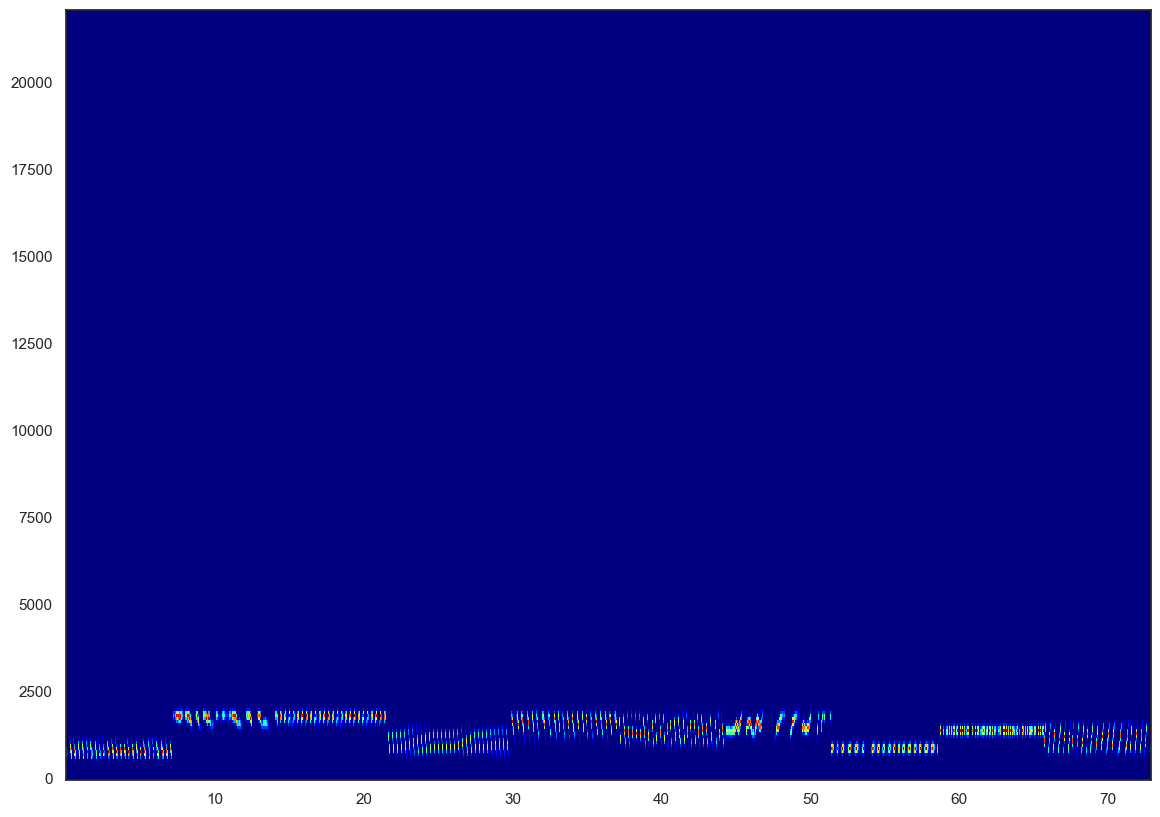

In [17]:
# Parameters we set
num_spec = 1
window_size = 100
stride = 10


folderpath_song = '/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Song_0/'



# For each spectrogram we will extract
# 1. Each timepoint's syllable label
# 2. The spectrogram itself
stacked_labels = [] 
stacked_specs = []
# Extract the data within the numpy file. We will use this to create the spectrogram
dat = np.load(f'{folderpath_song}synthetic_data.npz')
spec = dat['s']
times = dat['t']
frequencies = dat['f']
labels = dat['labels']
labels.shape = (1, labels.shape[0])
labels = labels.T

plt.figure()
plt.pcolormesh(times, frequencies, spec, cmap='jet')
plt.show()

Stack the spectrogram slices, the onset times, and the frequencies array. Create a unique color for each syllable. 

In [18]:
# Let's get rid of higher order frequencies
mask = (frequencies<4000)&(frequencies>600)
masked_frequencies = frequencies[mask]

subsetted_spec = spec[mask.reshape(mask.shape[0],),:]

stacked_labels.append(labels)
stacked_specs.append(subsetted_spec)

    
stacked_specs = np.concatenate((stacked_specs), axis = 1)
stacked_labels = np.concatenate((stacked_labels), axis = 0)

# Get a list of unique categories (syllable labels)
unique_categories = np.unique(stacked_labels)

# Create a dictionary that maps categories to random colors
category_colors = {category: np.random.rand(3,) for category in unique_categories}

spec_for_analysis = stacked_specs.T
window_labels_arr = []
embedding_arr = []
# Find the exact sampling frequency (the time in miliseconds between one pixel [timepoint] and another pixel)
dx = np.diff(times)[0]

# We will now extract each mini-spectrogram from the full spectrogram
stacked_windows = []
# Find the syllable labels for each mini-spectrogram
stacked_labels_for_window = []
# Find the mini-spectrograms onset and ending times 
stacked_window_times = []

# The below for-loop will find each mini-spectrogram (window) and populate the empty lists we defined above.
for i in range(0, spec_for_analysis.shape[0] - window_size + 1, stride):
    # Find the window
    window = spec_for_analysis[i:i + window_size, :]
    # Get the window onset and ending times
    window_times = dx*np.arange(i, i + window_size)
    # We will flatten the window to be a 1D vector
    window = window.reshape(1, window.shape[0]*window.shape[1])
    # Extract the syllable labels for the window
    labels_for_window = stacked_labels[i:i+window_size, :]
    # Reshape the syllable labels for the window into a 1D array
    labels_for_window = labels_for_window.reshape(1, labels_for_window.shape[0]*labels_for_window.shape[1])
    # Populate the empty lists defined above
    stacked_windows.append(window)
    stacked_labels_for_window.append(labels_for_window)
    stacked_window_times.append(window_times)

# Convert the populated lists into a stacked numpy array
stacked_windows = np.stack(stacked_windows, axis = 0)
stacked_windows = np.squeeze(stacked_windows)

stacked_labels_for_window = np.stack(stacked_labels_for_window, axis = 0)
stacked_labels_for_window = np.squeeze(stacked_labels_for_window)

stacked_window_times = np.stack(stacked_window_times, axis = 0)

# For each mini-spectrogram, find the average color across all unique syllables
mean_colors_per_minispec = np.zeros((stacked_labels_for_window.shape[0], 3))
for i in np.arange(stacked_labels_for_window.shape[0]):
    list_of_colors_for_row = [category_colors[x] for x in stacked_labels_for_window[i,:]]
    all_colors_in_minispec = np.array(list_of_colors_for_row)
    mean_color = np.mean(all_colors_in_minispec, axis = 0)
    mean_colors_per_minispec[i,:] = mean_color


In [19]:
# Let's save all the numpy arrays
np.save(folderpath_song+'stacked_windows.npy', stacked_windows)
np.save(folderpath_song+'labels_for_window.npy', labels_for_window)
np.save(folderpath_song+'masked_frequencies_lowthresh_600_highthresh_4000.npy', masked_frequencies)
np.save(folderpath_song+'stacked_window_times.npy', stacked_window_times)
np.save(folderpath_song+'mean_colors_per_minispec.npy', mean_colors_per_minispec)


## Perform a UMAP decomposition on our stacked spectrogram slice data

In [20]:
# Perform a UMAP embedding on the dataset of mini-spectrograms
reducer = umap.UMAP()
embedding = reducer.fit_transform(stacked_windows)
np.save(folderpath_song+'UMAP_Embedding_of_spec.npy', embedding)


## Bokeh Visualization

In [22]:
# The below function will save an image for each mini-spectrogram. This will be used for understanding the UMAP plot.
def embeddable_image(data, window_times, iteration_number):
    
    data.shape = (window_size, int(data.shape[0]/window_size))
    data = data.T 
    window_times = window_times.reshape(1, window_times.shape[0])
    plt.pcolormesh(window_times, masked_frequencies, data, cmap='jet')
    # let's save the plt colormesh as an image.
    plt.savefig(folderpath_song+'/Plots/Window_Plots/'+f'Window_{iteration_number}.png')
    plt.close()
    
    
for i in np.arange(stacked_windows.shape[0]):
    if i%10 == 0:
        print(f'Iteration {i} of {stacked_windows.shape[0]}')
    data = stacked_windows[i,:]
    window_times = stacked_window_times[i,:]
    embeddable_image(data, window_times, i)

Iteration 0 of 2501
Iteration 10 of 2501
Iteration 20 of 2501
Iteration 30 of 2501
Iteration 40 of 2501
Iteration 50 of 2501
Iteration 60 of 2501
Iteration 70 of 2501
Iteration 80 of 2501
Iteration 90 of 2501
Iteration 100 of 2501
Iteration 110 of 2501
Iteration 120 of 2501
Iteration 130 of 2501
Iteration 140 of 2501
Iteration 150 of 2501
Iteration 160 of 2501
Iteration 170 of 2501
Iteration 180 of 2501
Iteration 190 of 2501
Iteration 200 of 2501
Iteration 210 of 2501
Iteration 220 of 2501
Iteration 230 of 2501
Iteration 240 of 2501
Iteration 250 of 2501
Iteration 260 of 2501
Iteration 270 of 2501
Iteration 280 of 2501
Iteration 290 of 2501
Iteration 300 of 2501
Iteration 310 of 2501
Iteration 320 of 2501
Iteration 330 of 2501
Iteration 340 of 2501
Iteration 350 of 2501
Iteration 360 of 2501
Iteration 370 of 2501
Iteration 380 of 2501
Iteration 390 of 2501
Iteration 400 of 2501
Iteration 410 of 2501
Iteration 420 of 2501
Iteration 430 of 2501
Iteration 440 of 2501
Iteration 450 of 2501

In [23]:
# Specify an HTML file to save the Bokeh image to.
output_file(filename=f'{folderpath_song}Plots/umap.html')

# Convert the UMAP embedding to a Pandas Dataframe
spec_df = pd.DataFrame(embedding, columns=('x', 'y'))


# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x = embedding[:,0], y = embedding[:,1], colors=mean_colors_per_minispec))


# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size = 7, color = 'colors', source=source)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image" height="100" alt="@image" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))


# Set the image path for each data point
source.data['image'] = []
for i in np.arange(spec_df.shape[0]):
    source.data['image'].append(f'{folderpath_song}/Plots/Window_Plots/Window_{i}.png')

show(p)

save(p)


'/Users/ananyakapoor/Dropbox (University of Oregon)/Kapoor_Ananya/01_Projects/01_b_Canary_SSL/Canary_SSL_Repo/Song_0/Plots/umap.html'

## Preliminary Modeling to show proof-of-concept for contrastive learning

For contrastive learning to work well we need to ensure that similar syllables are concentrated together. This will allow us to easily pick positive and negative samples for a first-pass contrastive learning approach

We had been using HDBSCAN before but we should start off even simpler at first -- a nearest class center classifier and a support vector classifier. This will ensure that high clustering performance is coming from an informative embedding rather than a powerful clustering algorithm.

In [28]:
# %% Implementation of the NCC classifier 

actual_labels = np.max(stacked_labels_for_window, axis = 1)

unique_labels = np.unique(actual_labels)

avg_representation = np.zeros((unique_labels.shape[0], 2)) # 2nd dimension is UMAP embedding size

for lab in unique_labels:
    lab = int(lab)
    embedding_rows = np.where(actual_labels == lab)
    embedding_subset = np.squeeze(embedding[embedding_rows, :])
    avg_representation[lab, :] = np.mean(embedding_subset, axis = 0)
    
pred_labels = []
for i in np.arange(embedding.shape[0]):
    dist_metric = np.sum((embedding[i,:] - avg_representation)**2, axis = 1)
    pred_labels.append(np.argmin(dist_metric))
    

acc_value = np.mean(actual_labels == pred_labels)

# This shows that the representations of syllables form centroid like geometry
# in representation space. 

from sklearn.metrics.cluster import v_measure_score


v_measure_score(actual_labels, np.array(pred_labels))

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an instance of SVC with a linear kernel
svc_classifier = SVC(kernel='linear')

# Train the classifier on the training data
svc_classifier.fit(embedding, actual_labels)

# Make predictions on the test data
y_pred = svc_classifier.predict(embedding)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(actual_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.98


We have near perfect accuracy -- makes sense because this is a toy dataset. The next steps will be to use the UMAP decomposition for contrastive learning + neural networks